In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim # For gradient descent

print(torch.__version__)

2.0.1+cpu


In [8]:
# This is the function that will be used to generate the truth data.
def truth_func(x1, x2):
    """
    Compute a piecewise function value based on inputs x1 and x2.
    
    Parameters:
    - x1, x2: Inputs for which the function value needs to be computed.
    
    Returns:
    - Function value based on the given conditions.
    - This function returns two values, y1 and y2.
    """
    
    # Check bounds for x1 and x2
    if not (-1 <= x1 <= 1) or not (-1 <= x2 <= 1):
        raise ValueError('Both x1 and x2 must be in the range [-1, 1]')

    # Determine the function value of y1
    if x1 >= 0:
        if x2 >= 0:
            y1 = (x1-0.5)**2 + (x2-0.5)**2
        else:
            y1 = np.sin(x1) + np.sin(x2)
    else:
        if x2 >= 0:
            y1 = 0 if x1 < -0.5 else 1
        else:
            y1 = abs(x1 + 0.5) + abs(x2 + 0.5)
    
    # Determine the function value of y2

    y2 = np.sinc(3*(x1**2) + 3*(x2**2)) * 10

    return y1, y2

def normalize_data(y1_data, y2_data, inverse=False):
    """
    Normalize the data to 0 to 1 range. Or, if inverse is True, then denormalize the data to the original range.
    
    Parameters:
    - y1_data: Data for y1.
    - y2_data: Data for y2.

    Returns:
    - Normalized data for y1 and y2.
    """
    # The input data is already in the range [-1, 1], so we just need to normalize the output data
    y1_max = 1.0
    y1_min = -1.0
    y2_max = 10.0
    y2_min = -3.0
    
    if not inverse:
        y1_data_norm = (y1_data - y1_min) / (y1_max - y1_min)
        y2_data_norm = (y2_data - y2_min) / (y2_max - y2_min)
    else:
        y1_data_norm = y1_data * (y1_max - y1_min) + y1_min
        y2_data_norm = y2_data * (y2_max - y2_min) + y2_min

    return y1_data_norm, y2_data_norm

class DNN(nn.Module):
    def __init__(self, input_size, layer1_size, layer2_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, layer1_size)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(layer1_size, layer2_size)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(layer2_size, output_size)
        self.act_out = nn.Sigmoid()


    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act_out(self.fc3(x))

        return x

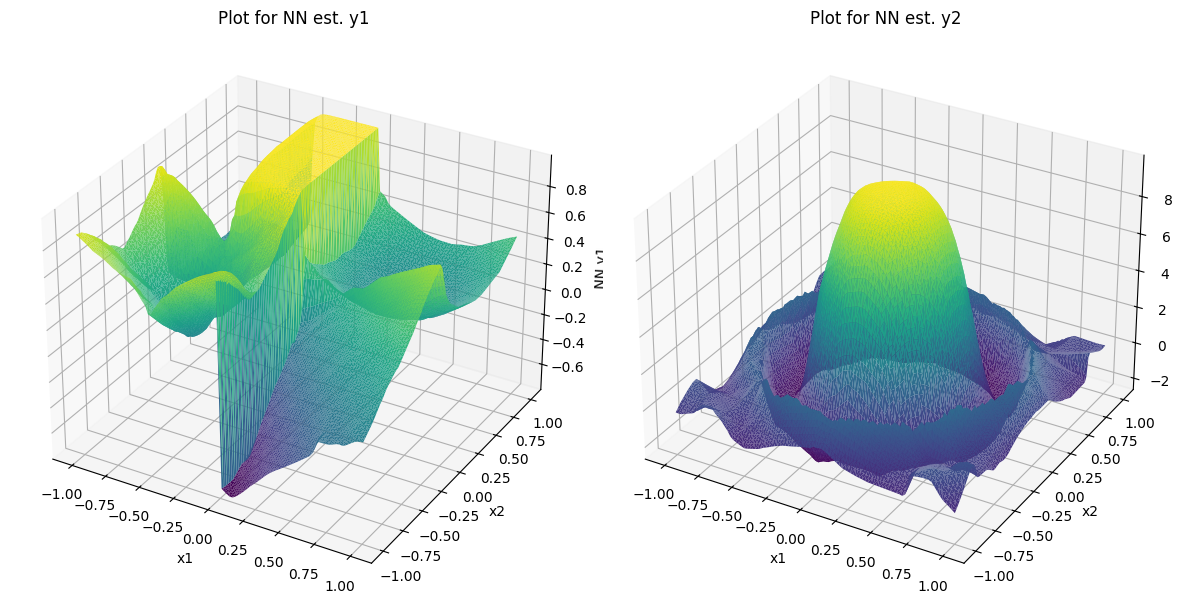

In [9]:
# lets plot the output of the neural network and compare it to the truth function.
input_size = 2
layer1_size = 128
layer2_size = 64
output_size = 2

model = DNN(input_size, layer1_size, layer2_size, output_size)
# Load the best model
model.load_state_dict(torch.load('trained_models/DNN_1HL128_2HL64.pt'))

# Generate the data points
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)

X1_points_NN = []
X2_points_NN = []
Y1_points_NN = []
Y2_points_NN = []


for x1_i in x1:
    for x2_i in x2:
        X1_points_NN.append(x1_i)
        X2_points_NN.append(x2_i)

        output = model(torch.Tensor([x1_i, x2_i]))
        y1_i, y2_i = normalize_data(output[0].item(), output[1].item(), inverse=True) 

        Y1_points_NN.append(y1_i)
        Y2_points_NN.append(y2_i)


# Create the 3D plot
fig = plt.figure(figsize=(12, 6))  # Adjusting the size for better visualization

# First subplot for x1, x2, and y1
ax1 = fig.add_subplot(121, projection='3d')  # 121 means: 1 row, 2 columns, first plot
ax1.plot_trisurf(X1_points_NN, X2_points_NN, Y1_points_NN, cmap='viridis')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('NN y1')
ax1.set_title('Plot for NN est. y1')

# Second subplot for x1, x2, and y2
ax2 = fig.add_subplot(122, projection='3d')  # 122 means: 1 row, 2 columns, second plot
ax2.plot_trisurf(X1_points_NN, X2_points_NN, Y2_points_NN, cmap='viridis')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('NN y2')
ax2.set_title('Plot for NN est. y2')

plt.tight_layout()  # Adjusts the plots so that they fit nicely
plt.show()

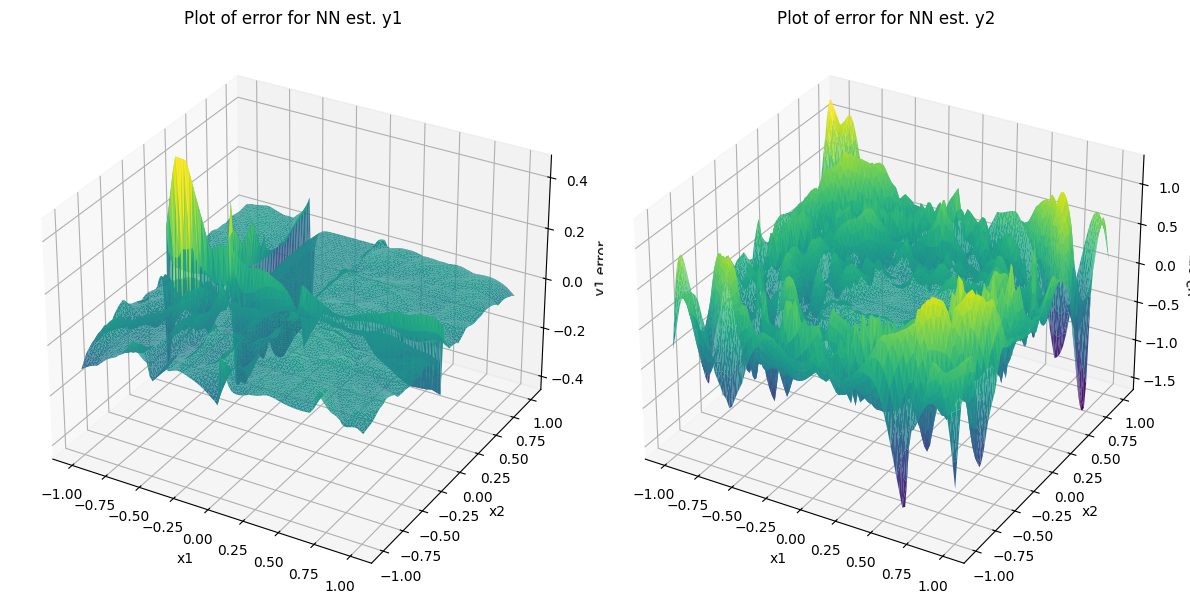

In [10]:
# Let's plot error 

# Generate the data points
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)

X1_points = []
X2_points = []
Y1_points = []
Y2_points = []

for x1_i in x1:
    for x2_i in x2:
        X1_points.append(x1_i)
        X2_points.append(x2_i)

        y1_i, y2_i = truth_func(x1_i, x2_i)
        Y1_points.append(y1_i)
        Y2_points.append(y2_i)

Y1_error = []
Y2_error = []

for i in range(len(Y1_points_NN)):
    Y1_error.append(Y1_points_NN[i] - Y1_points[i])
    Y2_error.append(Y2_points_NN[i] - Y2_points[i])

# Create the 3D plot
fig = plt.figure(figsize=(12, 6))  # Adjusting the size for better visualization

# First subplot for x1, x2, and y1
ax1 = fig.add_subplot(121, projection='3d')  # 121 means: 1 row, 2 columns, first plot
ax1.plot_trisurf(X1_points, X2_points, Y1_error, cmap='viridis')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y1 error')
ax1.set_title('Plot of error for NN est. y1')

# Second subplot for x1, x2, and y2
ax2 = fig.add_subplot(122, projection='3d')  # 122 means: 1 row, 2 columns, second plot
ax2.plot_trisurf(X1_points, X2_points, Y2_error, cmap='viridis')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y2 error')
ax2.set_title('Plot of error for NN est. y2')

plt.tight_layout()  # Adjusts the plots so that they fit nicely
plt.show()